## Notebook 3: Calibrating Our Random Forest And Logistic Regression Models

Welcome to the 3rd notebook of my "Expected Goals Deep Dive" series. In this notebook, we will focus on "calibration". First, we will generate some out of the box scikit-learn plots to see if our models are calibrated, then we will investigate techniques to try to improve the calibration of our models. Finally, we will look at the drawbacks of the out of the box sci-kit learn implementation, and 

In the April 9th weekly Friends of Tracking Youtube series, FC Barcelona data scientist Javi Fernandez discussed building probabilistic models for soccer in the following way: "When we build a model that predicts a probability or an expectation, is that number actually accurate and do you feel comfortable taking that to a coach?”

Javi then goes on to say "We see a lot of companies building expected goals models that have different probabilities, and they are all trying to optimize their log loss error. If we don't measure probability calibration, we don't known if  when the model says 0.3, it actually means there is a 30% chance of a goal"

Link to video here (clip at around 45 minute mark): https://www.youtube.com/watch?v=kHTq9cwdkGA&t=

Another way to phrase calibration for the purposes of the tools developed in this notebook "if we predict an event to happen 20% of the time, does the event actually  happen 20% of the time?"

Without further ado, let's dive into this notebook

First, let's set up the data:

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from skmisc.loess import loess
import statsmodels.api as sm

In [2]:
shots_model = pd.read_csv('shots_design_matrix.csv')
shots_model=shots_model[shots_model['Distance'] < 75]

In [3]:
y=shots_model['Goal']
x_rf=shots_model.drop(['Goal', 'Unnamed: 0', 'firstName', 'lastName', 'label', 'venue', 'date', 'eventSec', 'matchPeriod'], axis=1)

Since the Random Forest and Logistic regression models use different features, we need to build a different design matrix for each model. The next cell builds the Logistic Regression design matrix

In [4]:
x_logreg=x_rf.copy()
x_logreg = x_logreg.drop(columns=['X', 'Y', 'side_of_field', 'left_foot','prev_touch', 
                                  'prev_pass', 'C', 'in_swinging', 'out_swinging',
                                 'rebound'])
x_logreg['strong_distance'] = x_logreg['strong_foot']*x_logreg['Distance']
x_logreg['strong_angle'] = x_logreg['strong_foot']*x_logreg['Angle']
x_logreg['free_kick_angle'] = x_logreg['free_kick']*x_logreg['Angle']
x_logreg['distance_angle'] = x_logreg['Distance']*x_logreg['Angle']
x_logreg['duel_header'] = x_logreg['prev_duel']*x_logreg['header']
x_logreg['distance_squared'] = x_logreg['Distance']*x_logreg['Distance']
x_logreg['strong_distance_squared'] = x_logreg['distance_squared']*x_logreg['strong_foot']

We need to split our models into train  and test

In [5]:
x_rf_train, x_rf_test, y_train, y_test = train_test_split(x_logreg, y, test_size=0.2, random_state=42)

In [6]:
x_logreg_train, x_logreg_test, y_train, y_test = train_test_split(x_logreg, y, test_size=0.2, random_state=42)

Just as a proof of concept, let's show that the two models use the same data for training and testing by showing that  the data indices of the training  sets are the same:

In [7]:
set(x_rf_train.index)-set(x_logreg_train.index)

set()

In [8]:
set(x_rf_test.index)-set(x_logreg_test.index)

set()

#####  A quick note about our change of Logistic  Regression implementation

In Notebook 2, when we fit and tested the Logistic Regression model, we used the ``statsmodels`` package to build the model. The reason for that was because the ``statsmodels``  implementation has better tools for visualizing coefficients  and p values, thus making it easier to build new features and see their impact on the model.

In this (and future) notebooks, we will use the ``sklearn`` implementation of Logistic Regression. The  reason behind the switch is that many of the tools we will utilize in this notebook are part of the ``sklearn`` packaage, which in some cases means that the code will be much smoother if the input model is compatible with the sklearn API. 

The main difference is that sklearn applies regularization to its models. In fact, to get the best implementation we should do a full cross validation procedure to find the optimal  regularization, but  alas we will use the default sklearn implementation.

For more information on this, please check out the following link: https://stackoverflow.com/questions/50428825/different-coefficients-scikit-learn-vs-statsmodels-logistic-regression

In the next few cells, we will investigate the difference in coefficients generated by the two models

In [9]:
sklearn_logistic_model = LogisticRegression(random_state=42, max_iter=1000).fit(x_logreg_train, y_train)

In [10]:
statsmodels_logistic_model = sm.GLM(endog=y_train,exog=x_logreg_train,data=shots_model, 
                                           family=sm.families.Binomial()).fit()
print(statsmodels_logistic_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                36207
Model:                            GLM   Df Residuals:                    36190
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9969.3
Date:                Mon, 18 May 2020   Deviance:                       19939.
Time:                        09:45:20   Pearson chi2:                 3.65e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
right_foot                

In [11]:
statsmodels_logistic_model.params-sklearn_logistic_model.coef_.reshape(17,)

right_foot                -0.001015
header                     0.013142
counter_attack             0.001534
strong_foot               -0.548051
Distance                   0.002757
Angle                     -0.048251
prev_cross                 0.021489
prev_smart_pass            0.027947
free_kick                  0.827065
prev_duel                  0.025276
strong_distance            0.034354
strong_angle               0.392454
free_kick_angle           -3.286147
distance_angle             0.006855
duel_header               -0.007244
distance_squared          -0.000114
strong_distance_squared   -0.000594
dtype: float64

We find that most of the outputs, except free_kick_angle and free kick (which are correlated), have almost identical coefficients.

To spot-check this, let's check the out of sample log loss on the 2 models:

In [12]:
y_hat = sklearn_logistic_model.predict_proba(x_logreg_test)
print("sklearn test set log loss: "+str(round(log_loss(y_test, y_hat), 5)))
y_hat = statsmodels_logistic_model.predict(x_logreg_test)
print("statsmodels test set log loss: " +str(round(log_loss(y_test, y_hat), 5)))

sklearn test set log loss: 0.28009
statsmodels test set log loss: 0.28006


The sklearn version performs marignally worse (by .0003), but not by a significant amount to cause alarm, especially since log-loss isn't the be all and end all

###  Using sklearn Calibration Curves

One of the most commonly used ways of testing to see if your model is calibrated is by using a "binned" plot. The following is a summary for how binned plots work: <br> <br>
<b> 1.) </b> Sort all of our probabilistic predictions<br>
<b> 2.) </b> Group these predictions into different bins (more on the methodology for that later) <br>
<b> 3.) </b> Compute the average prediction in each bin <br>
<b> 4.) </b> Compute the average number of times the event happened in each bin <br>
<b> 5) </b> Plot the average prediction against the average occurence.

In an ideal world, our average prediction will match the average n

Let's fit our Random Forest Model before we dive in

In [13]:
random_forest_xg_model = RandomForestClassifier(random_state=42, n_estimators=500, criterion='gini', max_depth=8,
                                                max_features=8, min_samples_leaf=5, min_samples_split=250
                                               ).fit(x_rf_train, y_train)

Next, we will write a function to use the ``sklearn`` ``calibration_curve`` function and generate a plot specifically for our usage. This plot is very similar to the plots generated by @CleKraus and @p_robberechts (https://dtai.cs.kuleuven.be/sports/blog/how-data-availability-affects-the-ability-to-learn-good-xg-models) in their work on Expected Goals. However, we will examine the consequences and assumptions implied by these plots, and propose methodologies to improve them

First, let's go through the inputs for this function, to help understand what the function does

<b> ``models`` </b>: This is a fitted models or list of fitted models (callables) that determine. The function assumes that the model has previously been fit on training data. <br>
<b> ``model_labels`` </b>: The label of the models we want to put in the legend of our plot. <br>
<b> ``calibration_type`` </b>: This determines the algorithm for determining the bins. Options are `uniform` and `quantile`. Defaults to ``uniform``. We will discuss the consequences of this choice later. <br>
<b> ``y_data`` </b>: The data used to identify the true labels <br>
<b> ``x_data`` </b>: The `x` data for each model that is part of the plot. Must be equal in length to ``models``. <br>
<b> ``plot_title`` </b>: The title of the final plot. <br>
<b> ``n_bins`` </b>: ``int``. The number of bins to group the data into. Defaults to 20.
<b> ``lim`` </b>: Optional argument. Used to shrink the x axis if we want to zoom in on a specific part of the curve.
<b> ``conf_intervals`` </b>: Optional argument. Adds confidence intervals around your plot. Only works properly if ``calibration_type`` is quantile


 

In [14]:
def generate_calibration_plot(models, model_labels, calibration_type, y_data, x_data,plot_title, n_bins=20, lim=None, conf_intervals=False):
    fig, ax = plt.subplots()
    
    # Used to determine how to scale the plot if the values don't go up to 
    max_val=0
    
    # If the user forgets to wrap the model/model labels and x data in a list, turn it into a list
    models = [models] if callable(models) else models
    model_labels = [model_labels] if isinstance(model_labels, str) or callable(model_labels) else model_labels
    x_data = [x_data] if callable(x_data) else x_data
    
    #Loop through all the models, our labels forthe models and the data to predict on
    for model, model_label, x in zip(models, model_labels, x_data):
        # Predict the probabilities on the test set
        y_hat = model.predict_proba(x)
        
        #Run the algorithm above: Separate the data by probability, compute the average prediction and 
        # each outcome in each
        y_bins, x_bins = calibration_curve(y_data, y_hat[:,1], n_bins=n_bins, strategy=calibration_type)
        # The following code will only run if we want to plot confidence intervals around each datapoint 
        # This uses the Poisson approximation for confidence intervals
        if conf_intervals:
            bin_size=len(y_data)/n_bins
            num_success=np.round(y_bins*bin_size, 0)
            lower_bounds, upper_bounds=scipy.stats.poisson.interval(0.95, num_success)
            lower_size = num_success-lower_bounds
            upper_size = upper_bounds-num_success
            lower_p_size = [x/bin_size for x in lower_size]
            upper_p_size = [x/bin_size for x in upper_size]
            errors=np.row_stack((lower_p_size, upper_p_size))
            plt.errorbar(x_bins, y_bins, yerr=errors, marker='o', linewidth=1, label=model_label, markersize=3)
            
        # If we don't want confidence intervals, then let's
        else:
            plt.plot(x_bins, y_bins, marker='o', linewidth=1, label=model_label, markersize=4)
            
        # Used to determine how to draw the plot
        max_val=max(max(y_bins), max(x_bins), max_val)
    
    # Plot some stuff
    plt.plot([0, max_val], [0, max_val], color = 'black', linewidth = 1, linestyle='--')
    fig.suptitle(plot_title)
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('True probability in each bin')
    if lim is not None:
        plt.xlim(lim[0], lim[1])
        plt.ylim(lim[0], lim[1]) 
    plt.legend()
    plt.show()
      

Let's start by building a comparison of our Logistic regression and Random Forest on our training set

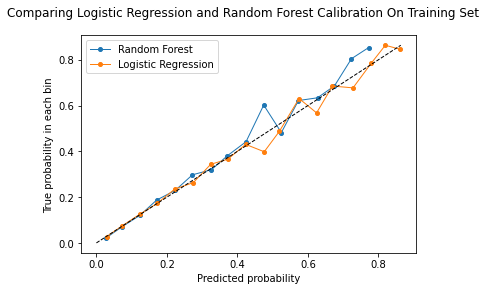

In [15]:
generate_calibration_plot(models=[random_forest_xg_model, sklearn_logistic_model], 
                          model_labels=['Random Forest', 'Logistic Regression'],
                          y_data=y_train,
                          x_data=[x_rf_train, x_logreg_train],
                          calibration_type='uniform', 
                          plot_title='Comparing Logistic Regression and Random Forest Calibration On Training Set')

Let's examine this for a second. It looks really good for low values, but then looks horrible for higher values. The most obvious takeaway is that the model isn't well calibrated to predicting high probabilities, but this is a dangerous assumption. Why is that? Let's examine the algorithm for binning more. In this example, we use the ``uniform`` methodology. In that case, we group everything equally by probability. Thus, we have a 0-0.05 bin, a 0.05-0.1 bin, a 0.1-0.15 bin etc. This methodology makes the graph misleading, as the vast majority of the datapoints will be on the low probabilities. Thus, we need to determine a more suitable way of generating this plot.

Fortunately, ``sklearn`` also supports the ``quantile`` method. The quantile method bins by ensuring that there are an equal number of datapoints in each bin. So, we'll try that out

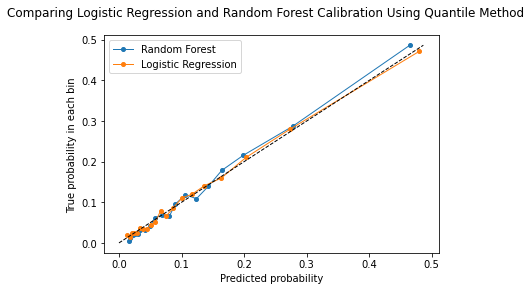

In [16]:
generate_calibration_plot(models=[random_forest_xg_model, sklearn_logistic_model], 
                          model_labels=['Random Forest', 'Logistic Regression'],
                          y_data=y_train,
                          x_data=[x_rf_train, x_logreg_train],
                          calibration_type='quantile', 
                          plot_title='Comparing Logistic Regression and Random Forest Calibration Using Quantile Method')

This looks a lot better. The Random Forest looks slightly worse than the Logistic Regression. 

We can also generate this plot with more bins:

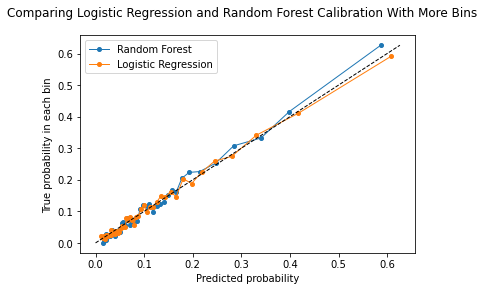

In [17]:
generate_calibration_plot(models=[random_forest_xg_model, sklearn_logistic_model], 
                          model_labels=['Random Forest', 'Logistic Regression'],
                          y_data=y_train,
                          x_data=[x_rf_train, x_logreg_train],
                          calibration_type='quantile',
                          n_bins=50,
                          plot_title='Comparing Logistic Regression and Random Forest Calibration With More Bins')

This looks decent, and very similar to the previous plot in fact, and we see that the Random Forest tends to underpredict for the higher values, while the Logistic Regression is liable to overpredict.

However, there are 2 problems with this approach so far. The obvious one is that we are testing calibration on the training set, which is kind of pointless because we want our model to generalize well to the testing  set. The other problem is that we don't have any uncertainty around our predictions, so we have no way (yet) of quantifying if the deviations from the 45 degree line are a problem

Let's generate the same plot on the test set, and also generate the plot zoomed in on values between 0 and 0.3, as that's where the vast majority of the datapoints are

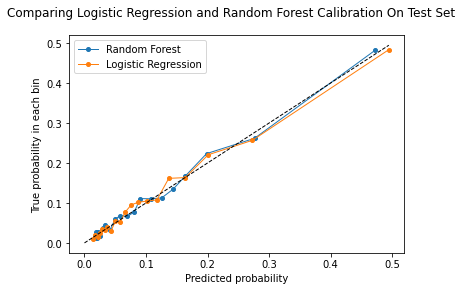

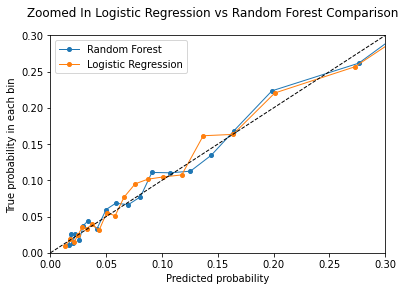

In [18]:
generate_calibration_plot(models=[random_forest_xg_model, sklearn_logistic_model], 
                          model_labels=['Random Forest', 'Logistic Regression'],
                          y_data=y_test,
                          x_data=[x_rf_test, x_logreg_test],
                          calibration_type='quantile', 
                          plot_title='Comparing Logistic Regression and Random Forest Calibration On Test Set')
generate_calibration_plot(models=[random_forest_xg_model, sklearn_logistic_model], 
                          model_labels=['Random Forest', 'Logistic Regression'],
                          y_data=y_test,
                          x_data=[x_rf_test, x_logreg_test],
                          calibration_type='quantile', 
                          lim=(0,0.3),
                          plot_title='Zoomed In Logistic Regression vs Random Forest Comparison')

The first plot looks pretty solid, as the two models look pretty similar in quality and deviate in the same places. The second plot gives us more detail on the differences between the two models. However, we don't see anything particularly alarming here either.

We still need to generate a methodology for quantifying uncertainity. We do this by using the Poisson approximation for the binomial distribution, and place 95% confidence intervals around each datapoint. More details on this can be  found here (https://www.statisticshowto.com/binomial-confidence-interval/#Poissontable) and here (https://stackoverflow.com/questions/14813530/poisson-confidence-interval-with-numpy), and the code is implemented in our function above

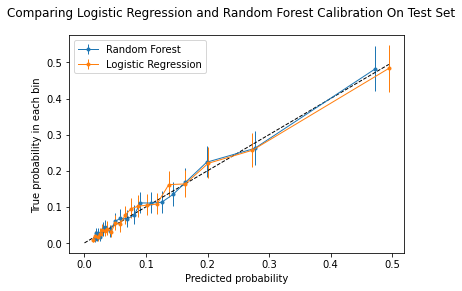

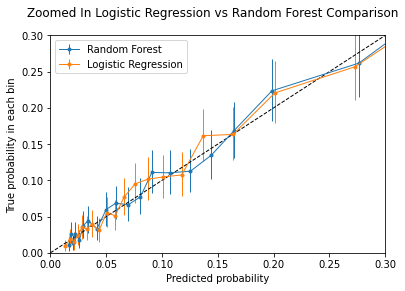

In [19]:
generate_calibration_plot(models=[random_forest_xg_model, sklearn_logistic_model], 
                          model_labels=['Random Forest', 'Logistic Regression'],
                          y_data=y_test,
                          x_data=[x_rf_test, x_logreg_test],
                          calibration_type='quantile', 
                          plot_title='Comparing Logistic Regression and Random Forest Calibration On Test Set',
                          conf_intervals=True)
generate_calibration_plot(models=[random_forest_xg_model, sklearn_logistic_model], 
                          model_labels=['Random Forest', 'Logistic Regression'],
                          y_data=y_test,
                          x_data=[x_rf_test, x_logreg_test],
                          calibration_type='quantile', 
                          lim=(0,0.3),
                          plot_title='Zoomed In Logistic Regression vs Random Forest Comparison',
                          conf_intervals=True)

This is pretty cool, all of our datapoints in both models fall within the confidence interval. However, in the next section we will attempt to improve the calibration of the model

### Calibrating Our Model Using ``sklearn``

In this section, we will demonstrate how to properly use ``sklearn`` to improve the calibration on our machine learning models

The way calibration works, is that it fits a model on your y labels using your predictions as the only predictor. Thus, if you always underpredict the target variable, the calibration technique will recognize this, and correspondingly increase your predictions, and create better calibration. This is particularly important, as the difference between a .3 and a .4 xG shot can make a world of difference when presenting to a coach or player.

For a more detailed description of calibration, please take a look at this excellent blog post: https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/

Fortunately, ``sklearn`` has a built in method to calibrate our models. In the next several cells, we will explore this function, and explore how to use it properly

We will use the Random Forest to illustrate the key points, before running the same set of cells for the Logistic Regression to get a true comparison

First, we will start by training a default ``CalibratedClassiier`` on the training set

In [20]:
calibrated_rf_model = CalibratedClassifierCV(random_forest_xg_model, 
                                             cv='prefit').fit(x_rf_train, y_train)

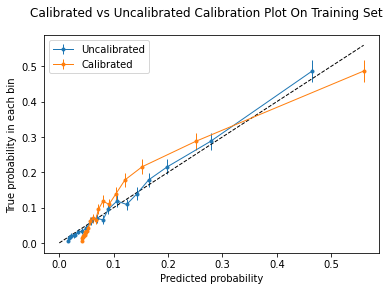

In [21]:
generate_calibration_plot(models=[random_forest_xg_model, calibrated_rf_model], 
                          model_labels=['Uncalibrated', 'Calibrated'],
                          y_data=y_train,
                          x_data=[x_rf_train, x_rf_train],
                          calibration_type='quantile', 
                          plot_title='Calibrated vs Uncalibrated Calibration Plot On Training Set',
                          conf_intervals=True)

Oh god, that looks horrible! Our calibrated Random Forest looks <b> worse </b> on the training set than our actual Classifier. What happened here?

The answer lies in the default arguments for this function. The default method for doing the classifier is ``sigmoid``. Sigmoid effectively assumes that the probabilities are `S` shaped, underpredicting at low values and overpredicting at high values. In fact, it effectively fits a logistic regression on all datapoints. Thus, we see our calibration curve go "too far" in the other direction. 

The other method for Calibration is ``isotonic``. An isotonic regression fits a piece wise function on the data. This makes more sense, as it does not make any assumptions on the curve of the data. However, this is prone to overfitting if there are too few samples

In [22]:
calibrated_isotonic_rf_model = CalibratedClassifierCV(random_forest_xg_model, 
                                                      cv='prefit', 
                                                      method='isotonic').fit(x_rf_train, y_train)

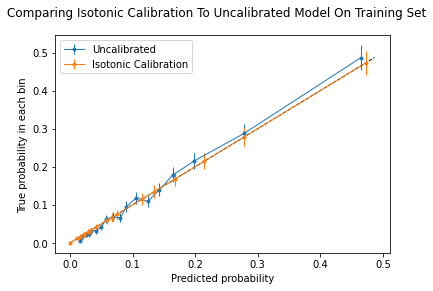

In [23]:
generate_calibration_plot(models=[random_forest_xg_model, calibrated_isotonic_rf_model], 
                          model_labels=['Uncalibrated', 'Isotonic Calibration'],
                          y_data=y_train,
                          x_data=[x_rf_train, x_rf_train],
                          calibration_type='quantile', 
                          plot_title='Comparing Isotonic Calibration To Uncalibrated Model On Training Set',
                          conf_intervals=True)

This looks a lot better. In fact, the data looks perfectly calibrated. Awesome!

Actually no, this is not awesome. We are overfitting here. We are training the model on a set of data, then calibrating the model on the same set of data and testing yet again on that set of data. Let's see how our calibrated model performs on our held out dataset

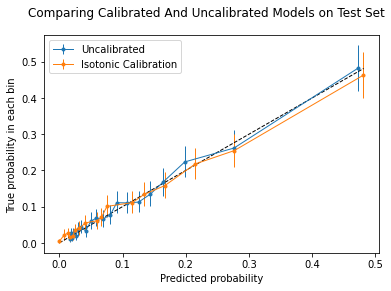

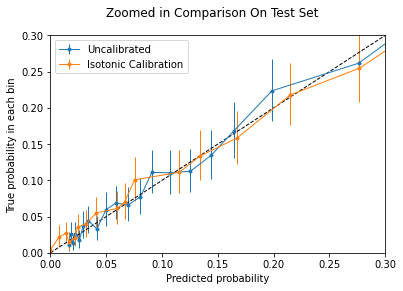

In [24]:
generate_calibration_plot(models=[random_forest_xg_model, calibrated_isotonic_rf_model], 
                          model_labels=['Uncalibrated', 'Isotonic Calibration'],
                          y_data=y_test,
                          x_data=[x_rf_test, x_rf_test],
                          calibration_type='quantile', 
                          plot_title='Comparing Calibrated And Uncalibrated Models on Test Set',
                                                  conf_intervals=True)

generate_calibration_plot(models=[random_forest_xg_model, calibrated_isotonic_rf_model], 
                          model_labels=['Uncalibrated', 'Isotonic Calibration'],
                          y_data=y_test,
                          x_data=[x_rf_test, x_rf_test],
                          calibration_type='quantile', 
                          lim=(0, 0.3),
                          plot_title='Zoomed in Comparison On Test Set',
                          conf_intervals=True)

This looks pretty similar in performance to before. In some places the calibrated classiier looks better, and in  other places the previous model looks better.

However, there is still a problem with our methodology. We are training and  calibrating our model on the same set of data. In fact, we need to apply our calibrations on predictions our original model hasn ever seen, before then testing  the combo-model on our final test set. Thus, we need to break our training set up into another train test set. Now we have 3 datasets. <br>

<b> 1.) </b> A training (labeled train_2) that is used to train the base machine learning model (Random Forest or Logistic Regression). <br>
<b> 2.) </b> A validation set, which is used to train the CalibrationClassifier using the predictions from the machine learning model as  an input. <br>
<b> 3.) </b> A test set, which is used to determine the quality of our final model.

In [25]:
x_rf_train_2, x_rf_val, y_train_2, y_val = train_test_split(x_rf_train, y_train, test_size=0.25, random_state=42)

In [26]:
smaller_random_forest = RandomForestClassifier(random_state=42, 
                                               n_estimators=500, 
                                               criterion='gini', 
                                               max_depth=8,
                                               max_features=6, 
                                               min_samples_leaf=15, 
                                               min_samples_split=300).fit(x_rf_train_2, y_train_2)

In [27]:
calibrated_val_rf = CalibratedClassifierCV(smaller_random_forest, 
                                           cv='prefit',
                                            method='isotonic').fit(x_rf_val, y_val)

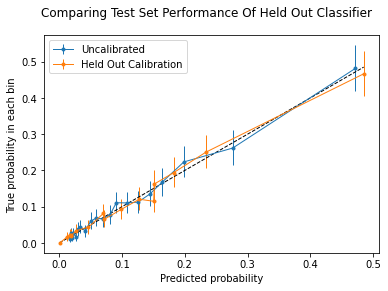

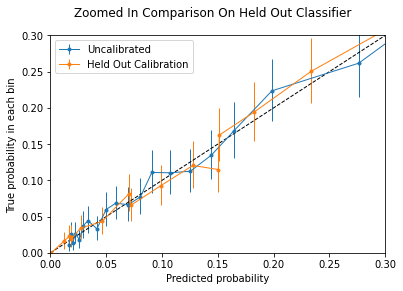

In [28]:
generate_calibration_plot(models=[random_forest_xg_model, calibrated_val_rf], 
                          model_labels=['Uncalibrated', 'Held Out Calibration'],
                          y_data=y_test,
                          x_data=[x_rf_test, x_rf_test],
                          calibration_type='quantile',
                          plot_title='Comparing Test Set Performance Of Held Out Classifier',
                                                  conf_intervals=True)
generate_calibration_plot(models=[random_forest_xg_model, calibrated_val_rf], 
                          model_labels=['Uncalibrated', 'Held Out Calibration'],
                          y_data=y_test,
                          x_data=[x_rf_test, x_rf_test],
                          calibration_type='quantile',
                          lim=(0, 0.3),
                          plot_title='Zoomed In Comparison On Held Out Classifier',
                          conf_intervals=True)

This is pretty cool. The Calibrated Classifier performs better mostly across the board, except at the highest point (due to the nature of the isotonic regression) and one weird spot in the middle. We will take a look at how to generate a better plot for the outliers later.

Let's do the same process for a logistic regression

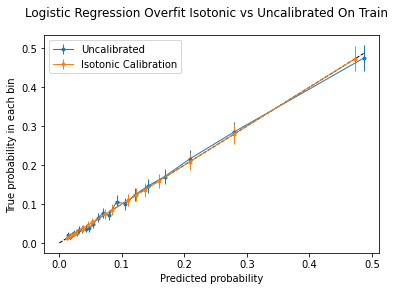

In [29]:
calibrated_logistic_model = CalibratedClassifierCV(sklearn_logistic_model, 
                                             cv='prefit', method='isotonic').fit(x_logreg_train, y_train)
generate_calibration_plot(models=[sklearn_logistic_model, calibrated_logistic_model], 
                          model_labels=['Uncalibrated', 'Isotonic Calibration'],
                          y_data=y_train,
                          x_data=[x_logreg_train, x_logreg_train],
                          calibration_type='quantile',
                          # Using n_bins=20 breaks, as one of the y values decreases. 
                          # This is a problem, but I won't address this in this notebook
                          n_bins=21,
                          plot_title='Logistic Regression Overfit Isotonic vs Uncalibrated On Train',
                          conf_intervals=True)

Like with the Random Forest, we find this is overfit.

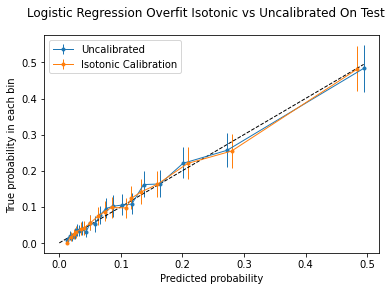

In [30]:
generate_calibration_plot(models=[sklearn_logistic_model, calibrated_logistic_model], 
                          model_labels=['Uncalibrated', 'Isotonic Calibration'],
                          y_data=y_test,
                          x_data=[x_logreg_test, x_logreg_test],
                          calibration_type='quantile', 
                          plot_title='Logistic Regression Overfit Isotonic vs Uncalibrated On Test',
                          conf_intervals=True)

In [31]:
x_logreg_train_2, x_logreg_val, y_train_2, y_val = train_test_split(x_logreg_train, 
                                                                    y_train, 
                                                                    test_size=0.25,
                                                                    random_state=42)
smaller_logreg = LogisticRegression(random_state=42, max_iter=1000).fit(x_logreg_train_2, y_train_2)

In [32]:
calibrated_val_logreg = CalibratedClassifierCV(smaller_logreg, 
                                           cv='prefit',
                                            method='isotonic').fit(x_logreg_val, y_val)

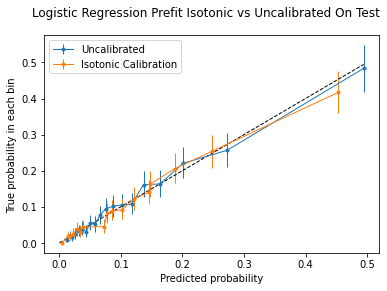

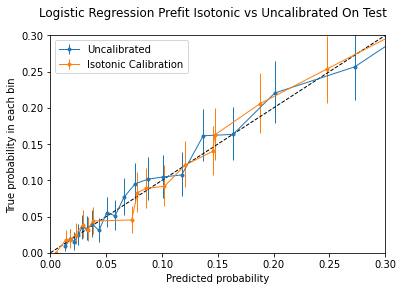

In [33]:
generate_calibration_plot(models=[sklearn_logistic_model, calibrated_val_logreg], 
                          model_labels=['Uncalibrated', 'Isotonic Calibration'],
                          y_data=y_test,
                          x_data=[x_logreg_test, x_logreg_test],
                          calibration_type='quantile', 
                          plot_title='Logistic Regression Prefit Isotonic vs Uncalibrated On Test',
                          conf_intervals=True)
generate_calibration_plot(models=[sklearn_logistic_model, calibrated_val_logreg], 
                          model_labels=['Uncalibrated', 'Isotonic Calibration'],
                          y_data=y_test,
                          x_data=[x_logreg_test, x_logreg_test],
                          calibration_type='quantile', 
                          plot_title='Logistic Regression Prefit Isotonic vs Uncalibrated On Test',
                          lim=(0,0.3),
                          conf_intervals=True)

We find some weirdness here where there's a big jump around 0.08 and 0.16, but overall the two models appear similar. 

Overall, we didn't find anything too exciting here. This is mainly due to interpretation of these plots being very manual and subject to bias from a human being, especially  when there's as little difference as there is now.

There are a couple major flaws with this approach for assessing calibration. The first problem is that since we are discretizing the bins, our plots are very sensitive to the number of bins chosen. Shifting some datapoints to different bins can have huge implications on the final bin plot. The second issue is that none of these plots do a good job of assessing high xG chances, as the highest xG on  these plots is around 0.5, and that calibration point takes in points with xG from 0.4 all the way to 1. We are effectively chosen to pick our poison, we either don't get enough datapoints in each bin to make a reasonable conclusion, or our extreme bin isn't representative.

###  LOESS plots for calibration

Another slightly less used method for calibration is a LOESS plot (locally estimated scatterplot smoothing). The  idea here is that for each datapoint in our dataset, we fit a locally weighted linear regressoin to determine the probability of that point. For example, if we are predicting a datapoint with an xG of 0.3, we will fit a regression where the other shots near 0.3 will have highest weight, and that weighting will decrease the further away you get from 0.3.

This has the advantage that at every point on our curve, all datapoints are being taken into account, and we aren't subject to the discretization the ``sklearn`` function subjects us to. A datapoint at 0.15 will take into account all data in a more appropriate way, not just the data in that bin. The following function generates our LOESS plots for us.

This function has very similar syntax to the function above, and we leverage the ``skmisc`` package to fit our LOESS regression. https://has2k1.github.io/scikit-misc/generated/skmisc.loess.loess.html

In [34]:
def generate_loess_calibration_plots(models, y_data, x_data, plot_title, labels, lim=None):
    for model, xs, label in zip(models, x_data, labels):
        x = model.predict_proba(xs)[:,-1]
        loess_reg = loess(x, y_data)
        loess_reg.fit()
        pred = loess_reg.predict(x, stderror=True)
        lowess = pred.values
        l = loess(x,y_data)
        l.fit()
        pred = l.predict(x, stderror=False)
        plt.plot(x, lowess, linewidth=0.1, label=label)
    plt.plot([0, 1], [0, 1], color = 'black', linewidth = 1, linestyle='--')
    plt.xlabel('Predicted probability')
    plt.ylabel('True probability in each bin')
    plt.title(plot_title)
    if lim is not None:
        plt.xlim(lim[0], lim[1])
        plt.ylim(lim[0], lim[1])
    legend=plt.legend()
    for legobj in legend.legendHandles:
        legobj.set_linewidth(2.0)
    plt.show()

We will first look at these plots for the naive vs Calibrated Random Forest

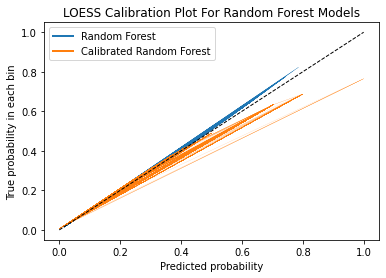

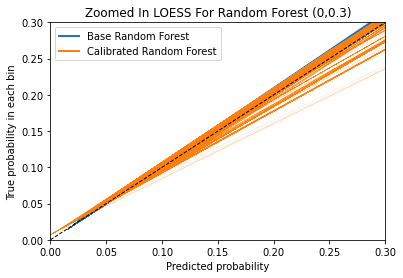

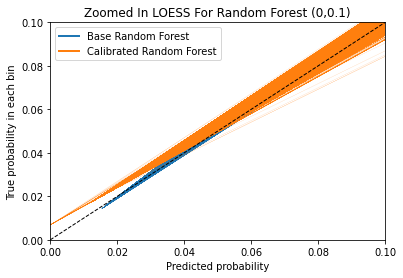

In [35]:
generate_loess_calibration_plots([random_forest_xg_model, calibrated_val_rf],
                                 y_test, 
                                 [x_rf_test, x_rf_test],
                                 labels=['Random Forest', 'Calibrated Random Forest'],
                                 plot_title='LOESS Calibration Plot For Random Forest Models')

generate_loess_calibration_plots([random_forest_xg_model, calibrated_val_rf],
                                 y_test, 
                                 [x_rf_test, x_rf_test],
                                 labels=['Base Random Forest', 'Calibrated Random Forest'],
                                 lim=(0,0.3),
                                 plot_title='Zoomed In LOESS For Random Forest (0,0.3)')
generate_loess_calibration_plots([random_forest_xg_model, calibrated_val_rf],
                                 y_test, 
                                 [x_rf_test, x_rf_test],
                                 labels=['Base Random Forest', 'Calibrated Random Forest'],
                                 lim=(0,0.1),
                                 plot_title='Zoomed In LOESS For Random Forest (0,0.1)')

From this, it appears the basic Random Forest is much better calibrated, and the calibrated Random Forest has overcompensated. Let's do the same comparison for Logistic Regression

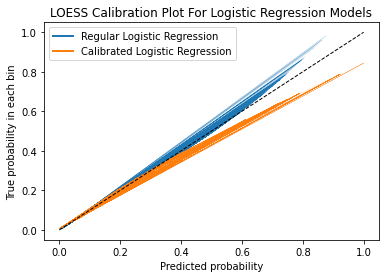

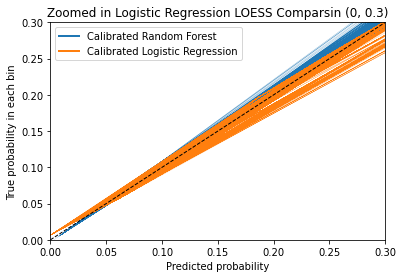

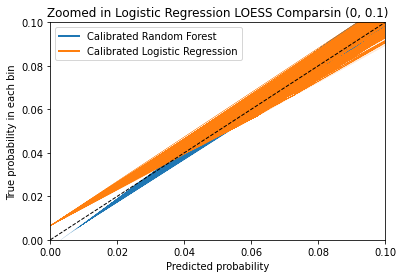

In [36]:
generate_loess_calibration_plots([sklearn_logistic_model, calibrated_val_logreg],
                                 y_test, 
                                 [x_logreg_test, x_logreg_test],
                                 labels=['Regular Logistic Regression', 'Calibrated Logistic Regression'],
                                 plot_title='LOESS Calibration Plot For Logistic Regression Models')

generate_loess_calibration_plots([sklearn_logistic_model, calibrated_val_logreg],
                                 y_test, 
                                 [x_logreg_test, x_logreg_test],
                                 labels=['Calibrated Random Forest', 'Calibrated Logistic Regression'],
                                 lim=(0,0.3),
                                 plot_title='Zoomed in Logistic Regression LOESS Comparsin (0, 0.3)')

generate_loess_calibration_plots([sklearn_logistic_model, calibrated_val_logreg],
                                 y_test, 
                                 [x_logreg_test, x_logreg_test],
                                 labels=['Calibrated Random Forest', 'Calibrated Logistic Regression'],
                                 lim=(0,0.1),
                                 plot_title='Zoomed in Logistic Regression LOESS Comparsin (0, 0.1)')

The regular Logistic Regression also looks a lot better. Odd. Let's compare the Random Forest And Logistic Regression then

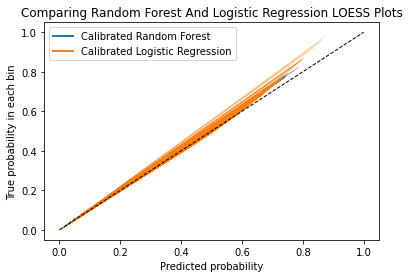

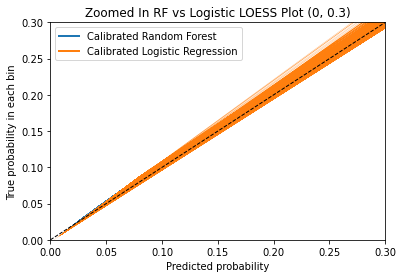

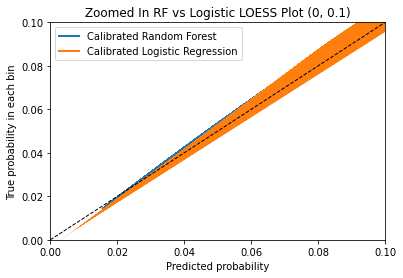

In [37]:
generate_loess_calibration_plots([random_forest_xg_model, sklearn_logistic_model],
                                 y_test, 
                                 [x_rf_test, x_logreg_test],
                                 labels=['Calibrated Random Forest', 'Calibrated Logistic Regression'],
                                 plot_title='Comparing Random Forest And Logistic Regression LOESS Plots')

generate_loess_calibration_plots([random_forest_xg_model, sklearn_logistic_model],
                                 y_test, 
                                 [x_rf_test, x_logreg_test],
                                 labels=['Calibrated Random Forest', 'Calibrated Logistic Regression'],
                                 lim=(0,0.3),
                                 plot_title='Zoomed In RF vs Logistic LOESS Plot (0, 0.3)')

generate_loess_calibration_plots([random_forest_xg_model, sklearn_logistic_model],
                                 y_test, 
                                 [x_rf_test, x_logreg_test],
                                 labels=['Calibrated Random Forest', 'Calibrated Logistic Regression'],
                                 lim=(0,0.1),
                                 plot_title='Zoomed In RF vs Logistic LOESS Plot (0, 0.1)')

These models look remarkably similar, although the Logistic regression takes on some higher values relative to Random Forest. This is interesting, and potentially is something that should be looked into in our final notebook.

###  Why we  still aren't totally there yet

So we've calibrated our models (or at least tried to), thus we've solved everything about expected goals models.

Well, not quite. We have found that our models are pretty well calibrated **globally**. By that, I mean when we average across all datapoints the probabilities are pretty good. Think of this example. If we have 10 datapoints that all have a true xG of 0.5, but our model spits out 0 for 5 of them and 1 for the other 5, our calibration plot would look pretty good. However, if  we looked at video of these incidents, it would be incredibly clear that the model is problematic.

While all these metrics and summary plots look good, we still don't have a true understanding of our xG model and how it works under various scenarios. How does it pick up heading vs shooting with the favored foot vs unfavored foot. Does it overfit to shots far away from the goal? What is the difference between being in an aerial duel and having a free header? These scenarios would tell us how well our models are **conditionally calibrated** given  various featuers.

In the end, our goal with these models (unless you work in the gambling industry) is to generate insights from the data and present them to a coach or a player. Generally, a coach thinks about the specific action on the pitch, effectively a mental video replay. Thus, you need to ensure that your xG model passes the "eye" test. That shot that was worth 0.5 xG that you are presenting to a coach to  prove  a point... is  that number believable? Do we have enough data on these types of shots to generate  a reliable  estimate? 

In the final notebook of this series, we will link our xG model to video to explore key differences between the 2 models and we will generate plots to see how our models perform under different conditions.